In [1]:
using Revise
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/preds2actuator/preds-not-commands`


In [2]:
using LinearAlgebra 
using Distributions
using RxInfer
using Plots
default(label="", grid=false, linewidth=3, margin=15Plots.pt)

includet("Muscles.jl"); using .Muscles

### Simulate muscle response

In [3]:
T = 20
tsteps = range(0, stop=1, length=T)

x_0 = 0.5
muscle = Muscle(init_state=x_0, mnoise_sd=1e-3)

muscle_x = [x_0]
muscle_u = []
muscle_y = []

inputs = [NormalMeanVariance(sin(t*2π)./2 + 1/2, 0.5) for t in tsteps[2:end]]

for (k,inp) in enumerate(inputs)
    
    step!(muscle, inp)    
    
    push!(muscle_u, muscle.prediction)
    push!(muscle_y, muscle.sensation)
    push!(muscle_x, muscle.state)
end

p11 = plot(xlabel="time [s]", ylabel="muscle state", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, muscle_x, color="blue")
scatter!(tsteps[2:end], rand.(muscle_y), color="red")

p12 = plot(xlabel="time [s]", ylabel="predictions")
plot!(tsteps[2:end], mean.(muscle_u), ribbon=std.(muscle_u), color="orange")

plot(p11,p12, layout=(1,2), size=(900,400))

UndefVarError: UndefVarError: `Δt` not defined

### Single planned trajectory

In [4]:
@model function planning_agent(T::Int, λ::Real, τ::Real)
  
    # States
    x = randomvar(T)

    # State prior
    m_0 = datavar(Float64)
    p_0 = datavar(Float64)
    x_0 ~ NormalMeanPrecision(m_0, p_0)
    
    # First state
    x[1] ~ NormalMeanPrecision(x_0,  λ)

    # Observation
    m_1 = datavar(Float64)
    p_1 = datavar(Float64)
    y_1 ~ NormalMeanPrecision(m_1, p_1)
    y_1 ~ NormalMeanPrecision(x[1], τ)
    
    # Goal priors
    y = randomvar(T-1)
    m_star = datavar(Float64)
    p_star = datavar(Float64)

    for t in 1:(T-1)

        # State transition
        x[t+1] ~ NormalMeanPrecision(x[t], λ)
        y[t]   ~ NormalMeanPrecision(x[t+1], τ)

        # Goal prior
        y[t] ~ NormalMeanPrecision(m_star, p_star)

    end
end

T = 9
m_star = 0.5
p_star = 1e1

m_1 = rand()
p_1 = 1e3

m_0 = 0.5
p_0 = 1e0

# Noise precisions
λ = 1e1
τ = 1e3

pp = inference(
    model = planning_agent(T, λ, τ),
    data = (m_1=m_1, p_1=p_1, m_0=m_0, p_0=p_0, m_star=m_star, p_star=p_star),
)

x_m = [m_0; mean.(pp.posteriors[:x])]
x_v = [1/p_0; var.(pp.posteriors[:x])]

10-element Vector{Float64}:
 1.0
 0.0019721048614984495
 0.03865692458773797
 0.044057065315305066
 0.04485295961643598
 0.04497687616841708
 0.04504104849931884
 0.045362532336761026
 0.047529680333139084
 0.0622497034498738

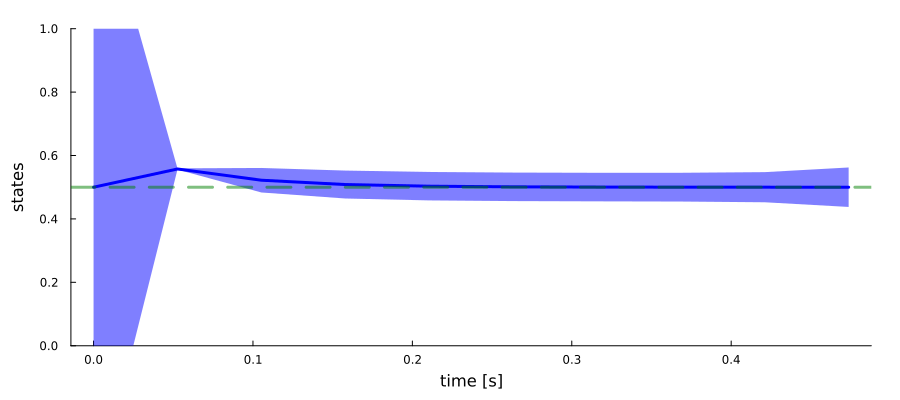

In [5]:
plot(xlabel="time [s]", ylabel="states", ylims=(0,1), size=(900,400))
plot!(tsteps[1:T+1], x_m, ribbon=x_v, color="blue")
hline!([m_star], color="green", linestyle=:dash, alpha=0.5)

### Reaction to goal priors

In [105]:
N = 10
T = 5
Δt = 0.01
tsteps = range(0, step=Δt, length=N)

# Noise precisions
λ = 1e4
τ = 1e1

# Initialize muscle
init_state = 0.0
muscle = Muscle(init_state=init_state, mnoise_sd=sqrt(inv(τ)), Δt=Δt)

# State prior
m_0 = 0.0
p_0 = 1e1

# Goal prior
m_star = 0.8
p_star = 1e3

sensations  = []
predictions = [NormalMeanPrecision(0.0, 10.0)]
states      = [NormalMeanPrecision(m_0, p_0)]

for k in 1:N-1

    # Send prediction to muscle
    step!(muscle, predictions[k])

    # Extract parameters of sensation
    m_1,p_1 = mean_precision(muscle.sensation)
    push!(sensations, muscle.sensation)

    # Update prediction towards muscle
    pp = inference(
        model = planning_agent(T, λ, τ),
        data = (m_1=m_1, p_1=p_1, m_0=m_0, p_0=p_0, m_star=m_star, p_star=p_star),
    )    

    # Extract prediction for time k+1
    push!(predictions, pp.posteriors[:x][2])

    # Update state prior
    m_0, p_0 = mean_precision(pp.posteriors[:x][1])
    push!(states, pp.posteriors[:x][1])
end

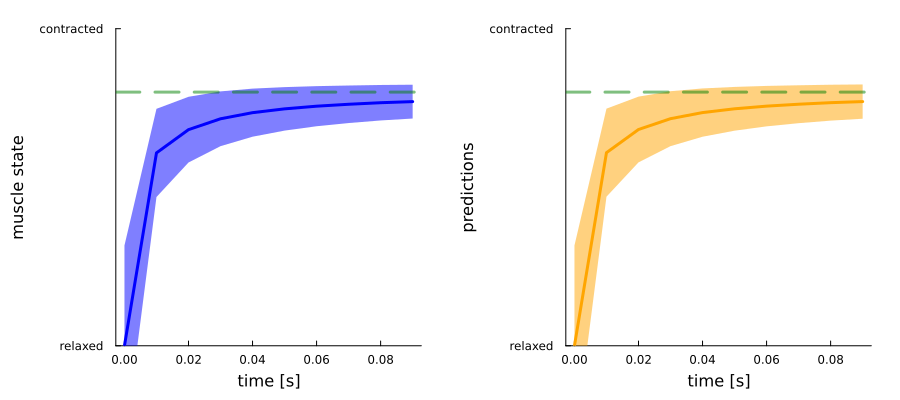

In [106]:
p21 = plot(xlabel="time [s]", ylabel="muscle state", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, mean.(states), ribbon=std.(states), color="blue")
hline!([m_star], color="green", linestyle=:dash, alpha=0.5)

p22 = plot(xlabel="time [s]", ylabel="predictions", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, mean.(predictions), ribbon=std.(predictions), color="orange")
hline!([m_star], color="green", linestyle=:dash, alpha=0.5)

plot(p21,p22, layout=(1,2), size=(900,400))